In [24]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


In [26]:
df = df[df.lineage_id.notna()]
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)


In [27]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']


In [28]:
celltype_dict = df_clean.groupby(['donor','lineage_id','vdj_sequence'])['Immune_All_Low_predicted_labels'].agg(list)
celltype_dict = celltype_dict.to_dict()

# Analyze lineage size by tissue

In [29]:
def calculate_within_lineage_diversity_statistics_number(dataframe, 
                                                         groupby, 
                                                         filter_column=None, 
                                                         suffix="", 
                                                         palette=None, 
                                                         title='all cells', 
                                                         show_legend=False):
    if filter_column is None:
        use_dataframe=dataframe
    else:
        use_dataframe=dataframe[filter_column]
    vdj_df = use_dataframe.groupby(['vdj_sequence', 'donor', 'lineage_id', groupby]).size().reset_index()
    lineage_sizes = vdj_df.groupby(['donor', groupby, 'lineage_id'])['vdj_sequence'].nunique().reset_index()
    lineage_sizes = lineage_sizes.rename(columns={'vdj_sequence':'n_vdj'})
    lineage_sizes['gb'] = lineage_sizes['donor'] + "_" + lineage_sizes[groupby]
    totals = lineage_sizes.groupby('gb')['n_vdj'].sum()
    lineage_sizes['rank'] = lineage_sizes.groupby(['donor', groupby])['n_vdj'].rank(method='max', ascending=False)
    lineage_sizes['total_gb'] = lineage_sizes['gb'].map(totals)
    lineage_sizes['fraction'] = lineage_sizes['n_vdj']/lineage_sizes['total_gb']
    lineage_sizes = lineage_sizes.sort_values(['donor', groupby, 'rank'])
    lineage_sizes['cumulative_size_seq'] = lineage_sizes.groupby(['donor', groupby])['fraction'].cumsum()

    lineage_sizes['first_rank'] = lineage_sizes.groupby(['donor', groupby])['n_vdj'].rank(method='first', ascending=False)
    lineage_sizes['fractional_rank'] = lineage_sizes['first_rank']/lineage_sizes['total_gb']
    
    n_singletons = lineage_sizes[lineage_sizes.n_vdj<2].groupby(['donor', groupby])['first_rank'].min()
    if palette is None:
        palette = {x:f'C{x[-1]}' for i, x in enumerate(sorted(n_singletons.reset_index()[groupby].values))}
    Dstats = []
    Ddict = {0.01:0, 0.05:1, 0.1:2}
    for D in Ddict.keys():
        dstat = lineage_sizes[lineage_sizes.cumulative_size_seq >= D].groupby(['donor', groupby])['first_rank'].first().reset_index()
        dstat['D'] = D
        Dstats.append(dstat)
    Dstats = pd.concat(Dstats)
    
    Dstats['singleton_cutoff'] = Dstats.apply(lambda x: n_singletons[(x.donor, x[groupby])], axis=1)
    Dstats = Dstats[Dstats.first_rank < Dstats.singleton_cutoff]
    # if (Dstats.first_rank >= Dstats.singleton_cutoff).any():
    #     print(Dstats[Dstats.first_rank >= Dstats.singleton_cutoff])
    Dstats['xvals'] = Dstats['donor'].map(lambda x: int(x[-1])-3.5)*0.1 + Dstats['D'].map(Ddict)
    min_max = Dstats.groupby(['donor','D'])['first_rank'].agg(['min', 'max'])
    fig, ax = plt.subplots(figsize=(3.,2.))
    ax.set_yscale('log')
    ax.set_ylim([0.8,2*10**3])
    # ax.set_title(title)
    g = sns.scatterplot(Dstats, x='xvals', hue=groupby, y='first_rank', ax=ax, palette=palette, legend=show_legend, s=10)
    
    if show_legend:
        sns.move_legend(g, frameon=False, loc='upper left', bbox_to_anchor=(1,1), title='')
    for donor in donors:
        for D in Ddict.keys():
            xval = (int(donor[-1])-3.5)*0.1 + Ddict[D]
            xvals= [xval, xval]
            try:
                yvals = min_max.loc[(donor, D), ['min', 'max']]
                ax.plot(xvals, yvals, color='0.5', zorder=-1, alpha=0.5, lw=1)
                # ax.text(xval, 1.5*yvals.iloc[-1], donor, color='0.5', va='bottom',rotation=90, ha='center')
            except KeyError:
                pass
    sns.despine(fig)
    ax.set_xlabel('Fraction of all\nunique heavy chains')
    ax.set_ylabel('Number of lineages\naccounting')
    ax.set_xticks(list(Ddict.values()), list(Ddict.keys()))
    ax.set_xlim([-0.5, 2.5])
    fig.tight_layout()
    fig.savefig(f'{FIGURE_OUTDIR}/D_stats_number{suffix}.pdf', bbox_inches='tight')

    perfect_diversity = []
    total_lineages = lineage_sizes.groupby(['donor',groupby])['lineage_id'].nunique().reset_index()
    for row_it, row in total_lineages.iterrows():
        perfect_diversity_sample = pd.DataFrame({'first_rank':np.arange(1,row.lineage_id+1),
                                                 'fractional_rank': np.arange(1,row.lineage_id+1)/row.lineage_id,
                                        'cumulative_size_seq': np.arange(1,row.lineage_id+1)/row.lineage_id})
        perfect_diversity_sample['donor'] = row.donor
        perfect_diversity_sample[groupby] = row[groupby]
        perfect_diversity.append(perfect_diversity_sample)
    perfect_diversity = pd.concat(perfect_diversity)

    fig, ax = plt.subplots(1,6, sharex=True, sharey=True, figsize=(6.5,2))
    ax = ax.flatten()
    
    for i, donor in enumerate(donors):
        sns.lineplot(lineage_sizes[lineage_sizes.donor==donor], 
                        y='fractional_rank',
                        x='cumulative_size_seq',
                        hue=groupby,
                        ax = ax[i],
                        palette=palette, 
                       legend=False)
        sns.lineplot(perfect_diversity[perfect_diversity.donor==donor], 
                        y='fractional_rank',
                        x='cumulative_size_seq',
                        hue=groupby,
                        ax = ax[i],
                        palette=palette, 
                       legend=False, 
                    linestyle='dotted')

        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_title(donor, weight='bold', color=donor_colors[donor])
        # ax[i].plot(np.logspace(-5,-2), 2*10**-5/np.logspace(-5,-2)**2, color='k')
    sns.despine(fig)
    fig.supxlabel('Fraction of all VDJs', fontsize='medium')
    fig.supylabel('Number of lineages needed', fontsize='medium')
    fig.tight_layout()
    fig.savefig(f'{FIGURE_OUTDIR}/diversity_stats_number{suffix}.pdf', bbox_inches='tight')
    

    fig, ax = plt.subplots(1,6, sharex=True, sharey=True, figsize=(7.5,2.))
    ax = ax.flatten()
    for i, donor in enumerate(donors):
        sns.lineplot(lineage_sizes[lineage_sizes.donor==donor], 
                        y='rank',
                        x='fraction',
                        hue=groupby,
                        ax = ax[i],
                        palette=palette, 
                        legend=False)
                    
        for it, row in n_singletons.reset_index().iterrows():

            if row['donor']==donor:
                ax[i].axhline(y=row.first_rank, color=palette[row[groupby]])
                
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_title(donor, weight='bold', color=donor_colors[donor])
        # ax[i].plot(np.logspace(-5,-2), 2*10**-5/np.logspace(-5,-2)**2, color='k')
    sns.despine(fig)
    fig.supxlabel('Fraction of VDJs in lineage', fontsize='medium')
    fig.supylabel('Number of greater\nor equal lineages', fontsize='medium')
    fig.tight_layout()
    fig.savefig(f'{FIGURE_OUTDIR}/lineage_size_distribution_number{suffix}.pdf', bbox_inches='tight')

    Dstats

# Calculate diversity statistics

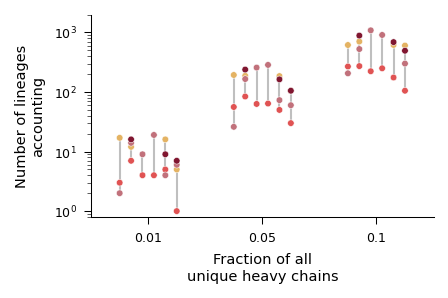

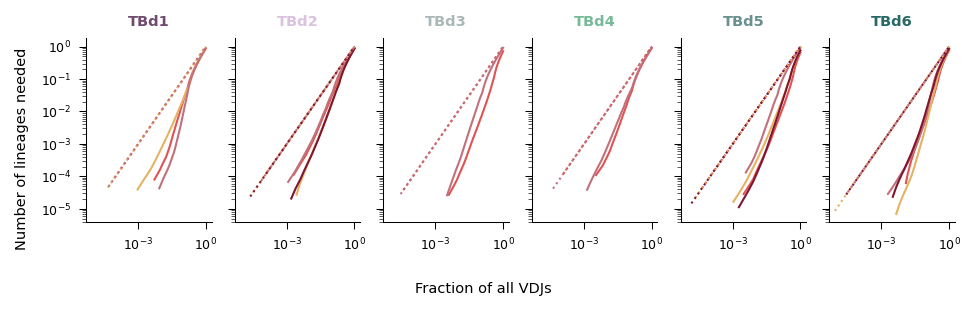

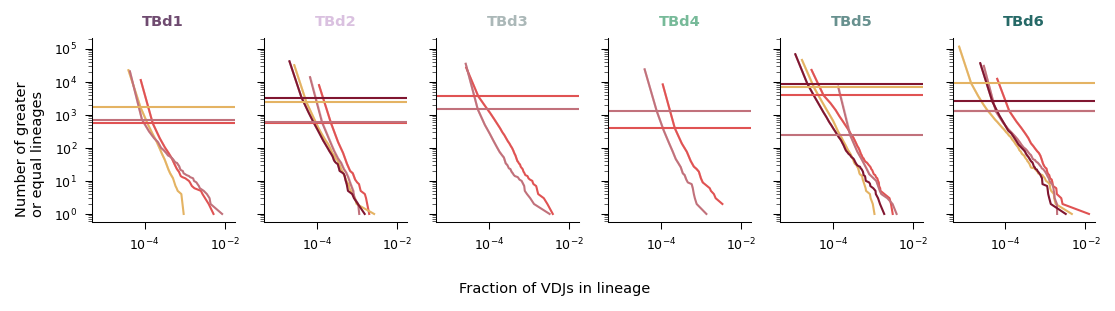

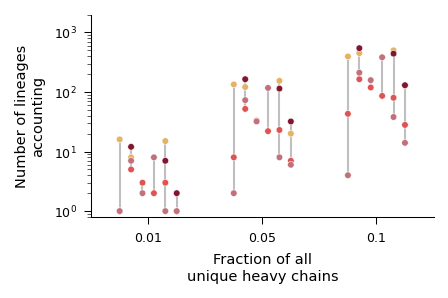

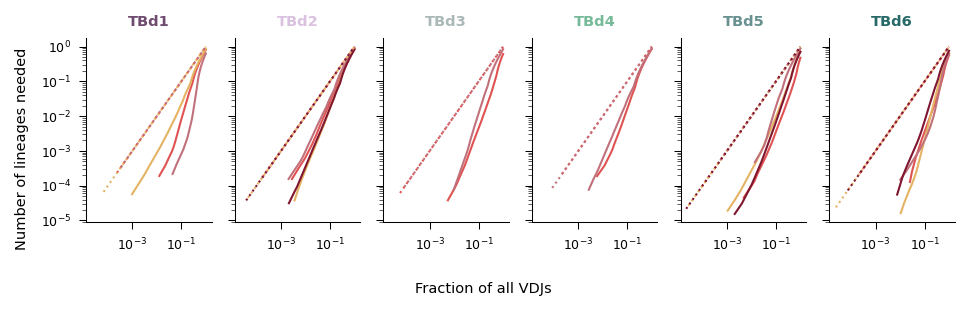

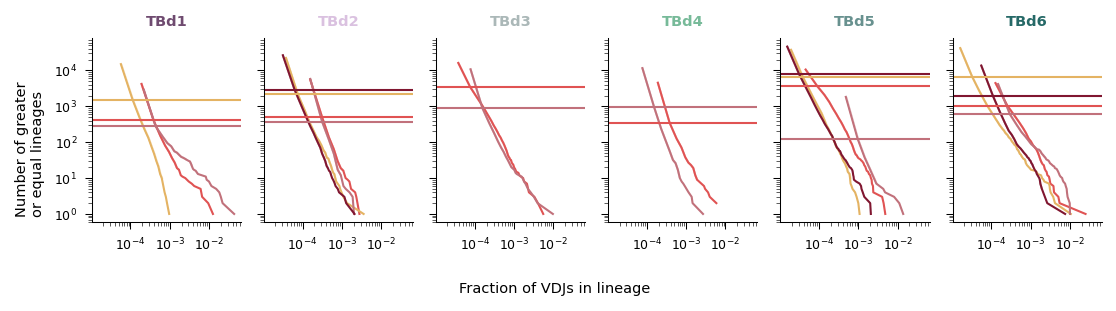

In [30]:


#all
calculate_within_lineage_diversity_statistics_number(df, 'tissue', filter_column=None, suffix="", palette=tissue_colors)
#hypermutated
calculate_within_lineage_diversity_statistics_number(df, 'tissue', filter_column=df.v_mismatch>0, suffix="_hypermutated", palette=tissue_colors, title='hypermutated cells')


In [118]:
def calculate_within_lineage_diversity_statistics_all_donors(dataframe, 
                                                         groupby, 
                                                         filter_column=None, 
                                                         suffix="", 
                                                         palette=None, 
                                                         title='all cells', 
                                                         show_legend=False,
                                                         NMIN=None,
                                                         n_replicates=1):
    print(groupby)
    
    if NMIN is None:
        use_dataframe=dataframe
    else:
        category_counts = dataframe.groupby(['donor',groupby])['vdj_sequence'].nunique()
        counts = dataframe.apply(lambda x: category_counts[(x.donor, x[groupby])], axis=1).fillna(0)
        use_dataframe = dataframe[counts>(NMIN-1)].copy()
        use_dataframe = use_dataframe.groupby(['donor',groupby,'vdj_sequence','lineage_id']).size().reset_index()        
    
    if filter_column is None:
        pass
    else:
        use_dataframe=dataframe[filter_column]
    use_dataframe['lineage_uid'] = use_dataframe['donor'] + "_" + use_dataframe['lineage_id'].astype(str)

    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(3,2))
    lineage_sizes_dfs = []
    for rep_it in range(n_replicates):
        print(f'working on replicate {rep_it}')
        if not (NMIN is None):
            downsampled_df = use_dataframe.groupby(['donor', groupby]).sample(NMIN)
        else:
            downsampled_df = use_dataframe
        
        vdj_df = downsampled_df.groupby(['vdj_sequence', 'lineage_uid', groupby]).size().reset_index()
        lineage_sizes = vdj_df.groupby([groupby, 'lineage_uid'])['vdj_sequence'].nunique().reset_index()
        lineage_sizes = lineage_sizes.rename(columns={'vdj_sequence':'n_vdj'})
        lineage_sizes['gb'] = lineage_sizes[groupby]
        totals = lineage_sizes.groupby('gb')['n_vdj'].sum()
        lineage_sizes['rank'] = lineage_sizes.groupby([groupby])['n_vdj'].rank(method='max', ascending=False)
        lineage_sizes['total_gb'] = lineage_sizes['gb'].map(totals)
        lineage_sizes['fraction'] = lineage_sizes['n_vdj']/lineage_sizes['total_gb']
        lineage_sizes = lineage_sizes.sort_values([groupby, 'rank'])
        lineage_sizes['cumulative_size_seq'] = lineage_sizes.groupby([groupby])['fraction'].cumsum()

        lineage_sizes['first_rank'] = lineage_sizes.groupby([groupby])['n_vdj'].rank(method='first', ascending=False)
        lineage_sizes['fractional_rank'] = lineage_sizes['first_rank']/lineage_sizes['total_gb']
        
        n_singletons = lineage_sizes[lineage_sizes.n_vdj<2].groupby([groupby])['first_rank'].min()
        if palette is None:
            palette = {x:f'C{x[-1]}' for i, x in enumerate(sorted(n_singletons.reset_index()[groupby].values))}
        lineage_sizes['replicate'] = rep_it
        lineage_sizes_dfs.append(lineage_sizes)
    lineage_sizes = pd.concat(lineage_sizes_dfs)

    fractional_rank_limits = lineage_sizes.groupby([groupby, 'cumulative_size_seq'])['fractional_rank'].agg(['min','max']).reset_index()
    fractional_rank_limits = fractional_rank_limits.sort_values([groupby, 'cumulative_size_seq'])
    for col in ['min','max']:
        for celltype in sorted(fractional_rank_limits[groupby].unique()):
            print(celltype, col, fractional_rank_limits.loc[fractional_rank_limits[groupby]==celltype, col].isna().sum() )
            fractional_rank_limits.loc[fractional_rank_limits[groupby]==celltype, col] = \
                fractional_rank_limits.loc[fractional_rank_limits[groupby]==celltype, col].interpolate(method='ffill')
            print('\t', fractional_rank_limits.loc[fractional_rank_limits[groupby]==celltype, col].isna().sum() )

            
        
    for celltype in sorted(fractional_rank_limits[groupby].unique()):
        celltype_data = fractional_rank_limits[fractional_rank_limits[groupby]==celltype]
        color = palette[celltype]
        # ax.plot(celltype_data['cumulative_size_seq'],
        #                 celltype_data['min'],
        #                 alpha=0.9,
        #                 lw=1, 
        #                 color=color)
        # ax.plot(celltype_data['cumulative_size_seq'],
        #                 celltype_data['max'], 
        #                 alpha=0.9,
        #                 lw=1, 
        #                 color=color, 
        #                 label=celltype)
        ax.fill_between(celltype_data['cumulative_size_seq'],
                                celltype_data['min'],
                                celltype_data['max'], 
                                alpha=0.5,
                                lw=0.5, 
                                color=color, 
                                label=celltype, 
                                interpolate=False)
        print(celltype_data[['cumulative_size_seq','min','max']])

        # print('plotting...')           
        # g = sns.lineplot(lineage_sizes, 
        #                 y='fractional_rank',
        #                 x='cumulative_size_seq',
        #                 hue=groupby,
        #                 ax = ax,
        #                 palette=palette, 
        #                 legend=False,
        #                 lw=0.9,
        #                 alpha=0.5)
        # # sns.move_legend(g, bbox_to_anchor=(1,1), frameon=False, loc='upper left')
    ax.legend(frameon=False, bbox_to_anchor=(1,1))
    line1, =ax.plot(np.logspace(-3,0,50), np.logspace(-3,0,50), zorder=-1, alpha=0.5, color='0.5')
    line1.set_dashes((2,2))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine(fig)
    ax.set_xlabel('Fraction of all VDJs')
    ax.set_ylabel('Fraction of lineages needed')
    fig.tight_layout()
    fig.savefig(f'{FIGURE_OUTDIR}/diversity_stats_number{suffix}_all_donors.pdf', bbox_inches='tight')
    

celltype
working on replicate 0
working on replicate 1
working on replicate 2
working on replicate 3
working on replicate 4
working on replicate 5
working on replicate 6
working on replicate 7
working on replicate 8
working on replicate 9
working on replicate 10
working on replicate 11
working on replicate 12
working on replicate 13
working on replicate 14
working on replicate 15
working on replicate 16
working on replicate 17
working on replicate 18
working on replicate 19
ABCs min 0
	 0
ASC-1 min 0
	 0
ASC-2 min 0
	 0
ASC-3 min 0
	 0
Memory B cells min 0
	 0
Naive B cells min 0
	 0
ABCs max 0
	 0
ASC-1 max 0
	 0
ASC-2 max 0
	 0
ASC-3 max 0
	 0
Memory B cells max 0
	 0
Naive B cells max 0
	 0
      cumulative_size_seq       min       max
0                0.002000  0.000667  0.000667
1                0.002667  0.000667  0.000667
2                0.003333  0.000667  0.000667
3                0.004000  0.000667  0.001333
4                0.004667  0.001333  0.001333
...                  

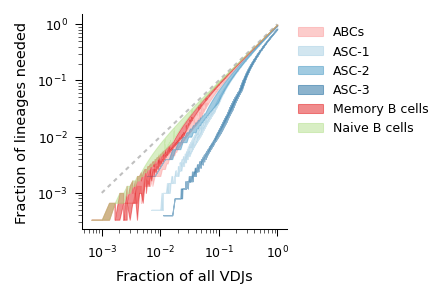

In [119]:

# celltypes
# celltype_counts = df_clean.groupby(['donor','celltype'])['vdj_sequence'].nunique()
# counts = df_clean.apply(lambda x: celltype_counts[(x.donor, x.celltype)], axis=1).fillna(0)
NMIN=500
# downsampled_df = df_clean[counts>(NMIN-1)]
# downsampled_df = downsampled_df.groupby(['donor','celltype','vdj_sequence','lineage_id']).size().reset_index()
# downsampled_df = downsampled_df.groupby(['donor', 'celltype']).sample(NMIN)
# groupby = 'celltype'
# suffix='_celltypist'
# calculate_within_lineage_diversity_statistics_number(downsampled_df, 
#                                                      groupby, 
#                                                      filter_column=filter_column, 
#                                                      suffix=suffix, 
#                                                      palette=bcelltype_colors_alt, 
#                                                      title='cell types', 
#                                                      show_legend=True)

calculate_within_lineage_diversity_statistics_all_donors(df_clean, 
                                                     groupby, 
                                                     suffix=suffix, 
                                                     palette=bcelltype_colors_alt, 
                                                     title='cell types', 
                                                     show_legend=True,
                                                     NMIN=NMIN, 
                                                     n_replicates=20
                                                     )


tissue
working on replicate 0
working on replicate 1
working on replicate 2
working on replicate 3
working on replicate 4
working on replicate 5
working on replicate 6
working on replicate 7
working on replicate 8
working on replicate 9
working on replicate 10
working on replicate 11
working on replicate 12
working on replicate 13
working on replicate 14
working on replicate 15
working on replicate 16
working on replicate 17
working on replicate 18
working on replicate 19
working on replicate 20
working on replicate 21
working on replicate 22
working on replicate 23
working on replicate 24
working on replicate 25
working on replicate 26
working on replicate 27
working on replicate 28
working on replicate 29
working on replicate 30
working on replicate 31
working on replicate 32
working on replicate 33
working on replicate 34
working on replicate 35
working on replicate 36
working on replicate 37
working on replicate 38
working on replicate 39
working on replicate 40
working on replicat

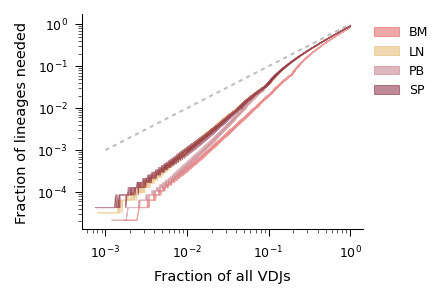

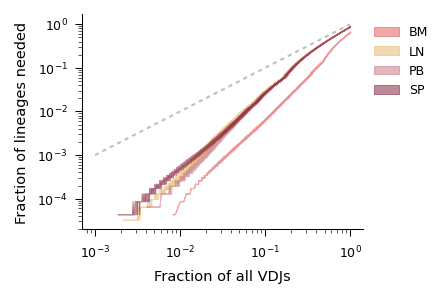

In [122]:
calculate_within_lineage_diversity_statistics_all_donors(df, 
                                                     'tissue', 
                                                     suffix='tissue', 
                                                     palette=tissue_colors, 
                                                     title='tissues', 
                                                     show_legend=True,
                                                     NMIN=7591, 
                                                     n_replicates=100
                                                     )

calculate_within_lineage_diversity_statistics_all_donors(df[df.v_mismatch>0], 
                                                     'tissue', 
                                                     suffix='tissue_hypermutated', 
                                                     palette=tissue_colors, 
                                                     title='tissues_hypermutated', 
                                                     show_legend=True,
                                                     NMIN=7591, 
                                                     n_replicates=100
                                                     )